# Preprocessing

In [2]:
# load in libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from textblob import Word
import json
import re
from nltk.corpus import stopwords
from math import log
import pandas as pd
import re
from unidecode import unidecode 

# read in files we want to use
users_df = pd.read_csv("BX-Users.csv")
books_df = pd.read_csv("BX-Books.csv")
ratings_df = pd.read_csv("BX-Ratings.csv")
world_countries_s = (pd.read_csv("World-Countries.csv")).iloc[:, 0]

## Cleaning Data

### Clean ISBNs
Here, we'll remove any records that have an invalid ISBN

In [3]:
# Check that the ISBN's are valid
def validateISBN(isbn: str):
    '''
    returns True if the isbn is valid and False otherwise
    '''
    # Get only letters or digits from the ISBN by removing the possible 
    # hyphens and spaces
    isbn = isbn.replace('-', '').replace(' ', '')
    
    # Verify the ISBN is the right length (either 10 or 13)
    if len(isbn) not in [10, 13]:
        return False
    
    # Verify ISBN for the case it's of length 10
    if (len(isbn)==10):
        digit_sum = 0
        for i in range(9): 
            # the first 9 characters must be digits
            if isbn[i].isdigit() and (0 <= int(isbn[i]) <= 9): 
                digit_sum += int(isbn[i]) * (10 - i)
            elif not isbn[i].isdigit():
                return False
        if isbn[9] == 'X':
            # X is worth 10
            digit_sum += 10
        elif isbn[9].isdigit():
            digit_sum += int(isbn[9])
            # check that the sum of all digits is divisible by 11
        return (digit_sum % 11 == 0)
    
    # Verfiy ISBN for the case it's of length 13
    else:
        # all the characters must be digits
        if isbn.isdigit() == False:
            return False
        # now we'll check the rest of the isbn's
        digit_sum = 0
        for i in range(12):
            if i%2==0:
                digit_sum += isbn[i]
            else:
                digit_sum += isbn[i]*3
        digit_sum = 10 - digit_sum if digit_sum != 0 else 0
        return digit_sum == int(isbn[-1])
    

#### Clean ISBNs in books_df

In [4]:
# Find the valid isbns in the new books csv
invalid_isbn_condition = (books_df["ISBN"].apply(validateISBN)==False)

# Let's see how many invalid isbn's there are and they are:
invalid_records = books_df[invalid_isbn_condition]
print(f"There are {len(invalid_records)} records with invalid ISBNs\n")
print(f"The invalid ISBNs are:\n")
print(invalid_records["ISBN"])

There are 1 records with invalid ISBNs

The invalid ISBNs are:

7399    039592720x
Name: ISBN, dtype: object


We see that there's only one invalid ISBN at records 7399 and the ISBN is only invalid because there's a lowercase 'x'. We'll manually fix it to be an uppercase 'X'

In [5]:
books_df.loc[7399, "ISBN"] = "039592720X"

#### Clean ISBNs in ratings_df

In [6]:
# Find the valid isbns in the new books csv
invalid_isbn_condition = (ratings_df["ISBN"].apply(validateISBN)==False)

# Let's see how many invalid isbn's there are and they are:
invalid_records = ratings_df[invalid_isbn_condition]
print(f"There are {len(invalid_records)} records with invalid ISBNs\n")
print(f"The invalid ISBNs are:\n")
print(invalid_records["ISBN"])

There are 4 records with invalid ISBNs

The invalid ISBNs are:

72566     039592720x
106228    039592720x
140240    039592720x
155055    039592720x
Name: ISBN, dtype: object


Again, we see that the invalid ISBN's are only invalid because they have a lowercase 'x' instead of an uppercase 'X'. We'll just manually fix this.

In [7]:
ratings_df.loc[72566, "ISBN"] = "039592720X"
ratings_df.loc[106228, "ISBN"] = "039592720X"
ratings_df.loc[140240, "ISBN"] = "039592720x"
ratings_df.loc[155055, "ISBN"] = "039592720X"

### Clean year of publication in books_df

Check all entries are integer years

In [8]:
# Check that all the publication data is integer
publication_entry_types = pd.Series()
publication_entry_types = books_df['Year-Of-Publication'].apply(type)
unique_types = publication_entry_types.unique()
print(f"The unique entry types in the publication date features are: {unique_types}")

The unique entry types in the publication date features are: [<class 'int'>]


Remove any impossible publication years. (i.e., books published in the future)

In [9]:
# condition for impossible books
impossible_condition = books_df['Year-Of-Publication'] > 2024
books_df.loc[impossible_condition, "Year-Of-Publication"] = np.nan

Remove any publication years that are outliers. 
Define outliers to be 3std's outside the mean.

In [10]:
# calculate then mean and standard deviation
mean_publish_year = books_df['Year-Of-Publication'].mean()
std_publish_year = books_df['Year-Of-Publication'].std()

# define the range of which values are acceptable
min_accepted_val = mean_publish_year - 3*std_publish_year
max_accepted_val = mean_publish_year + 3*std_publish_year
out_of_range_condition = ((books_df['Year-Of-Publication'].notna()) & 
                          (books_df['Year-Of-Publication']<min_accepted_val) 
                          | (books_df['Year-Of-Publication']>max_accepted_val))

# replace any publishing dates outside the accepted range with Nan
books_df.loc[out_of_range_condition, "Year-Of-Publication"] = np.nan

Impute any missing entries with the mean

In [11]:
# Check if there's any missing publication years
print(f"There is {sum(books_df['Year-Of-Publication'].isna())} missing publication years")

There is 317 missing publication years


In [12]:
# Find and impute the missing publication year with the mean
mean_publication_year = round(books_df['Year-Of-Publication'].mean())
books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].fillna(mean_publication_year)

In [13]:
# Now just to make sure everything is clean, we'll integer convert everything
books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].apply(int)

### Clean Authors in books_df

Some helper functions

In [14]:
def delete_punctuation(text):
    '''Deletes all punctuation excluding full stops'''
    punct = r'[^\w\s\.]'
    return re.sub(punct, '', text)

def replace_full_stop(text):
    '''Replaces full stops with a whitespace. This is to deal with cases 
    of initials i.e. S.E.Williams'''
    full_stop = r'\.'
    return re.sub(full_stop, ' ', text)

def delete_middle_names(text):
    '''Deletes middle name to create more uniformity between spellings 
    of author names'''
    middle_name = r"^(\w+)\s+(\w+\s+)?(\w+)$"
    return re.sub(middle_name, r"\1 \3", text)


def delete_spaces(text):
    '''Deletes all whitespace to uniformise name strings'''
    space = r'\s'
    return re.sub(space, '', text)

Now actually clean the data

In [15]:
#Begin casefolding - remove uppercase letters
books_df['Book-Author'] = books_df['Book-Author'].str.lower()

#Remove non-ASCII characters and replace with their closest ASCII equivalent
#books['Book-Author'] = books['Book-Author'].apply(lambda x: 
# unidecode(x).replace('?', ''))

#Creates a dataframe that contains stepwise columns to reach the final 
#condensed and cleaned author name spellings
#NOTE: Does not work if we apply the steps straight to books['Book-Author'] 
# so we need to create a separate dataframe
edit = pd.DataFrame({'1':books_df['Book-Author']})
edit['2'] = books_df['Book-Author'].apply(delete_punctuation)
edit['3'] = edit['2'].apply(replace_full_stop)
edit['4'] = edit['3'].apply(delete_middle_names)
edit['5'] = edit['4'].apply(delete_spaces)

books_df['Book-Author'] = edit['5']

### Clean Countries in users_df

Analyse the data do see what se actually need to clean

In [16]:
# Let's see how the countries data looks before we clean
print(f"Currently, the unique country entries are:")
print(f"{sorted(list(users_df['User-Country'].apply(str).unique()))}\n")
print(f"Before cleaning, there are {len(users_df['User-Country'].unique())} " 
      f"unique country entries\n")

# Let's see how many country entries are missing
total_records = len(users_df)
total_missing = len(users_df.loc[users_df["User-Country"].isna()])
print(f"The number of records missing a country entry is: {total_missing}\n")
print(f"This means {total_missing/total_records*100:.2f}% of the records " 
      f"are missing a country\n")

Currently, the unique country entries are:
[' afghanistan"', ' albania"', ' alderney"', ' algeria"', ' america"', ' angola"', ' antarctica"', ' antigua and barbuda"', ' argentina"', ' aroostook"', ' aruba"', ' australia"', ' austria"', ' bahamas"', ' bahrain"', ' barbados"', ' belgium"', ' belize"', ' benin"', ' bermuda"', ' bolivia"', ' brazil"', ' bulgaria"', ' burma"', ' c"', ' camden"', ' cameroon"', ' canada"', ' cananda"', ' caribbean sea"', ' catalonia"', ' catalunya"', ' cayman islands"', ' chile"', ' china"', ' colombia"', ' costa rica"', ' croatia"', ' csa"', ' cuba"', ' cyprus"', ' czech republic"', ' denmark"', ' deutschland"', ' dominican republic"', ' ecuador"', ' egypt"', ' england"', ' españa"', ' estonia"', ' euskal herria"', ' everywhere and anywhere"', ' far away..."', ' ferrara"', ' finland"', ' framingham"', ' france"', ' germany"', ' ghana"', ' greece"', ' grenada"', ' guatemala"', ' guernsey"', ' guinea"', ' honduras"', ' hong kong"', ' hungary"', ' iceland"', ' 

In [17]:
STOP_WORDS = set(stopwords.words("english")) # a set of english stop words

Some Helper Functions:

In [18]:
def strip_stopwords(phrase):
      '''
      Removes english stop words from a given phrase
      Note: phrase must be in all lowercase
      '''
      # split phrase up into separate words so we can detect stop words
      words = phrase.split()
      # filter out the stop words 
      important_words = [word for word in words if word not in STOP_WORDS]
      #return the important words
      return " ".join(important_words)
      
def reformat_word(word):
    '''
    Reformat words to have all punctuation and trailing space stripped, 
    turn ampersands into the word "and" and lowercase everything
    '''
    # make everything lowercase
    final_word = word.lower()
    
    # Remove punctuation
    # Regex pattern that identifies all non letter or white space characters
    punctuation_rule = r'[^\w\s]'
    # removing punctuation
    final_word = re.sub(punctuation_rule, '', final_word)
    
    # Remove stop words
    final_word = strip_stopwords(final_word)

    # Strip trailing white spaces
    final_word = final_word.strip()
    
    # just need to lowercase everything, then done reformatting!
    return final_word

def spell_correct_country(phrase):
      '''
      Tries to spell correct country words using textblob.
      Since textblob is not very good at spell checking phrases, we'll have
      to split up country names into individual words if they're longer
      than one word
      
      Will return a valid country word if it can, otherwise it will return NaN
      '''
      world_countries = list((pd.read_csv("World-Countries.csv")).iloc[:, 0])
      words = phrase.split()
      if (len(words)) == 1:
            # we only need to correct one word
            
            # here's some potential corrections
            correction_options = [x[0] for x in Word(words[0]).spellcheck()]
            # make sure the corrected words in the format we want
            correction_options = [reformat_word(x) for x in correction_options]
            
            # see if any of the correction options are in our countries
            for option in correction_options:
                  if option in world_countries:
                        # one of the correction options is a valid country
                        # return this option
                        return option
                  else:
                        # we couldn't find a valid correction :(
                        return np.nan
      else:
            # we need to correct each word individually
            corrected_words = []
            for word in words:
                  # find the best spelling correction of the word
                  corrected_word = Word(word).correct()
                  # reformat to lowercases, removed punctuation
                  # and add it to the corrected words list
                  corrected_words.append(reformat_word(corrected_word))
            # now we recombine all the corrected words
            final_correction = ' '.join(corrected_words)
            # check if the final corrected word is a valid country and return
            if final_correction in world_countries:
                  # yes! the correction is a valid country
                  return final_correction
            else:
                  # after everything, we still couldn't obtain a valid country
                  return np.nan

The actual function to clean the data:

In [19]:
def clean_countries(user_data):
      '''
      cleans up the country feature in a user_data dataframe and returns the 
      cleaned dataframe
      '''
      # Make a dictionary of common country acronyms or alternative spellings after 
      # a quick observation of the data
      with open("Popular-Alternative-Country-Names.json", "r") as file:
            alt_country_names = json.load(file)

      # Add a cloumn to the dataframe verifying if each record's country entry is
      # cleaned
      user_data["Clean-Complete"] = False

      # here's how we'll call the records with country entries yet to clean 
      uncleaned_condition = user_data["Clean-Complete"] == False

      # MARK ANY RECORDS WE DON'T NEED TO FIX

      # Any country entries that are NaN will be considered complete, we won't
      # try impute the country here as it only adds confusion to our analysis
      # and won't make the data easier to work with
      user_data.loc[user_data["User-Country"].isna(),"Clean-Complete"] = True
      # reupdate the uncleaned_condition
      uncleaned_condition = user_data["Clean-Complete"] == False

      # REFORMAT REMAINING RECORDS TO BE EASIER TO WORK WITH

      # We'll now reformat the country entries to have all punctuation and 
      # trailing space stripped, turn ampersands into the word "and" and 
      # lowercase everything
      user_data.loc[uncleaned_condition, "User-Country"] = user_data.loc[
                  uncleaned_condition, "User-Country"].apply(str).apply(
                                                            reformat_word)

      # Check the country entries to see if they're a valid country. If yes, 
      # change "clean-Complete" tag to True
      valid_country_condition = user_data["User-Country"].isin(world_countries_s)
      user_data.loc[uncleaned_condition & valid_country_condition, 
                    "Clean-Complete"] = True
      # reupdate the uncleaned_condition
      uncleaned_condition = user_data["Clean-Complete"] == False

      ## CONVERTING ACRONYMS TO FULL COUNTRY NAMES

      # Find and convert as many acronym country entries into the formal country name
      # Here's how we'll index for acronymed entries
      acronym_detected_condition = user_data["User-Country"].apply(lambda x: x in 
                                                                  alt_country_names)
      # Now we convert the acronym
      user_data.loc[acronym_detected_condition, "User-Country"] = user_data.loc[
            acronym_detected_condition, "User-Country"].apply(
                  lambda x: alt_country_names[x])
      # Tag the record as "clean-Complete"=True
      user_data.loc[acronym_detected_condition, "Clean-Complete"] = True
      # reupdate the uncleaned_condition
      uncleaned_condition = user_data["Clean-Complete"] == False

      ## SPELL CHECK TIME! (Last step!)
      # try to spell check all the remaining entries
      user_data.loc[uncleaned_condition, "User-Country"] = user_data.loc[
            uncleaned_condition, "User-Country"].apply(spell_correct_country)

      # Remove the "Clean-Complete" column, we don't need it anymore
      user_data = user_data.drop("Clean-Complete", axis=1)
      
      # Return the cleaned country data
      return user_data

Okay, now we'll actually clean the countries

In [20]:
users_df = clean_countries(users_df)

Some final analysis on the cleaned data

In [21]:
print(f"After cleaning, the unique country entries are:")
print(f"{sorted(list(users_df['User-Country'].apply(str).unique()))}\n")
print(f"Hence, there are now {len(users_df['User-Country'].unique())} " 
      f"unique country entries\n")
total_missing = len(users_df.loc[users_df["User-Country"].isna()])
print(f"After cleaning, the total number of NaN country entries " 
      f"has risen to {total_missing}\n")
print(f"This means {total_missing/total_records*100:.2f}% of the records " 
      f"are now missing a country\n")

After cleaning, the unique country entries are:
['afghanistan', 'albania', 'algeria', 'angola', 'antigua barbuda', 'argentina', 'aruba', 'australia', 'austria', 'bahamas', 'bahrain', 'barbados', 'belgium', 'belize', 'benin', 'bermuda', 'bolivia', 'brazil', 'bulgaria', 'burma', 'cameroon', 'canada', 'cayman islands', 'chile', 'china', 'colombia', 'costa rica', 'croatia', 'cuba', 'cyprus', 'czech republic', 'denmark', 'dominican republic', 'ecuador', 'egypt', 'estonia', 'finland', 'france', 'germany', 'ghana', 'greece', 'grenada', 'guatemala', 'guernsey', 'guinea', 'honduras', 'hong kong', 'hungary', 'iceland', 'india', 'indonesia', 'iran', 'ireland', 'israel', 'italy', 'jamaica', 'japan', 'jersey', 'kazakhstan', 'kenya', 'kuwait', 'laos', 'latvia', 'luxembourg', 'macedonia', 'madagascar', 'malaysia', 'malta', 'mauritius', 'mexico', 'moldova', 'mongolia', 'morocco', 'mozambique', 'nan', 'nepal', 'netherlands', 'new zealand', 'niger', 'nigeria', 'norway', 'oman', 'pakistan', 'palau', 'pan

### Clean Ages users_df

In [22]:
# definition of constants that are string representations of different data 
# type. Use to tag the data type of each age entry in "BX-Users.csv"
NAN = "NaN"
INT = "int"
STR = "str"

STEP 1: Make sure all the ages are in either an integer format or NaN

In [23]:
# make a column saying whether the name entry is Nan, integer, or a 
# string that needs to be cleaned

# initially assume the input of each age entry is a string
users_df["age_entry_type"] = pd.Series([STR] * len(users_df))

# find the age entries that are Nan and tag them in the "age_entry_type" 
# column
nan_age_condition = users_df["User-Age"].isnull()
users_df.loc[nan_age_condition, "age_entry_type"] = NAN

# find the age entries that are integer and indicated them in the 
# "age_entry_type" column
num_age_condition = pd.Series([False] * len(users_df))
# which non-Nan records have integer entries for ages?
is_int_age = (users_df.loc[nan_age_condition==False, "User-Age"]
                                            .apply(lambda x: x.isdigit()))
# which record indices are of integer ages?
int_ages_indices = is_int_age[is_int_age].index
# update "age_entry_type" column to tag integer ages
users_df.loc[int_ages_indices, "age_entry_type"] = INT

# clean up the string entries for the age that come in the formal {%d%d"}
# this is all we have to do to convert all string entries into numbers as it
# was found all string entries came in this form
str_age_condition = users_df["age_entry_type"] == STR
users_df.loc[str_age_condition, "User-Age"] = (users_df
        .loc[str_age_condition, "User-Age"].apply(lambda x: x.strip('"')))

# turn all the now numerical age entries into type int() for analysis
users_df.loc[nan_age_condition==False, "User-Age"] = (users_df
        .loc[nan_age_condition==False, "User-Age"].apply(lambda x: int(x)))


INTERMISSION: 

Check to see how many entries are NaN, how many are integers, and how many are neither integers nor strings. The goal is for us to only have NaN or integer ages

In [24]:
nan_ages_count = len(users_df.loc[nan_age_condition])
int_ages_count = sum(users_df.loc[:,"User-Age"].apply(lambda x: type(x)==int))
neither_nan_nor_int_ages_count = (len(users_df) - nan_ages_count 
                                    - int_ages_count)
print(f"NaN count: {nan_ages_count}\nint count: {int_ages_count}" 
      f"\nneither NaN nor int count: {neither_nan_nor_int_ages_count}")

NaN count: 18952
int count: 29347
neither NaN nor int count: 0


 STEP 2: Find all out of range ages and set age to NaN

In [25]:
out_of_range_condition = ((users_df["User-Age"] < 0) | 
                          (users_df["User-Age"] > 120))
users_df.loc[out_of_range_condition, "User-Age"] = np.nan

STEP 3: Imputation

In [26]:
# group users by isbn
grouped_users_by_book = ratings_df.groupby("ISBN")
# make a series that will store each isbn and its median age
unique_isbns = list(grouped_users_by_book.groups.keys())
median_age_of_book_s = pd.Series(index=unique_isbns)
# compute median age of each book
for (isbn, user_rating_info) in grouped_users_by_book:
    # find the user records for that book, but within the users_df
    users_ids_wanted = list(user_rating_info["User-ID"])
    user_records_wanted = users_df[users_df["User-ID"].isin(users_ids_wanted)]
    
    if user_records_wanted["User-Age"].isna().all():
        # all age records for this isbn are Nan, don't calculate the median
        median_age = np.nan
    else:
		# calculate the median age for the book 
        median_age = user_records_wanted["User-Age"].median()
        
    # assign the median age to the median_age_of_book series
    median_age_of_book_s.loc[isbn] = median_age

# compile all books each user has reviewed 
grouped_books_of_each_user = ratings_df.groupby("User-ID")["ISBN"]

# time to impute! For each user that has a Nan age, try to impute in the 
# median age of the readers from all the books they read

# first, here's a list of all the users with a Nan age
users_with_missing_age = set(users_df.loc[nan_age_condition, "User-ID"])

for user, isbns in grouped_books_of_each_user:
    if user in users_with_missing_age:
        # gather median ages from all books reviewed
        ages_of_each_book = median_age_of_book_s[list(isbns)]

        if not ages_of_each_book.isna().all():
            # calculate the age to impute
            imputed_age = ages_of_each_book.median()
            # impute the age
            users_df.loc[users_df["User-ID"]==user, "User-Age"] = imputed_age
            # remove user from missing age set
            users_with_missing_age.discard(user)

# now impute the remaining median ages
# calculate the median age of the entire dataset
median_age = users_df["User-Age"].median()

# impute the median for any users with missing ages
imputer = SimpleImputer(strategy="median")
age_2d_column = users_df["User-Age"].values.reshape(-1, 1)
imputer.fit(age_2d_column)
users_df.loc[:,"User-Age"] = imputer.transform(age_2d_column)

# make sure all ages are integers
users_df.loc[:,"User-Age"] = users_df.loc[:,"User-Age"].apply(round)

Done cleaning ages, just drop any misc columns we added to our DataFrame

In [27]:
# Done cleaning ages, just drop any misc columns we added to our DataFrame
users_df = users_df.drop("age_entry_type", axis=1)

### Clean Ratings in ratings_df

In [28]:
# let's check if any ratings are misisng
print(f"There are {sum(ratings_df['Book-Rating'].isna())} missing ratings")

There are 0 missing ratings


In [29]:
# now let's see if any ratings are outside the range [0, 10]
out_of_range_condition = ((ratings_df['Book-Rating']>10) | 
                          (ratings_df['Book-Rating']<0))
print(f"There are {len(ratings_df[out_of_range_condition])} "
      f"ratings out of the range [0, 10]")

There are 0 ratings out of the range [0, 10]


There doesn't seem to be anything obviously wrong with the ratings data, hence we won't be cleaning it any further.

## Adding new metrics

### Country Frequency of Each Book
Here we will find the number of unique countries that have reviewed each book and add that value to out books_df

In [30]:
def find_user_country(userid):
    '''
    function for finding the country of a user given their userid
    '''
    # find the relevant user info
    user_country = users_df.loc[users_df["User-ID"]==userid, "User-Country"]
    
    # return the country
    if not user_country.empty:
        return user_country.item()
    
    else:
        return np.nan

In [31]:
# add column to ratings_df called "User-Country"
ratings_df["User-Country"] = ratings_df.loc[:,"User-ID"].apply(find_user_country)

# The number of unique countries that have rated each book
country_freq_per_book = ratings_df.groupby('ISBN')['User-Country'].nunique()

# Turn data into a DataFrame
country_freq_per_book_df = country_freq_per_book.reset_index()

# Rename the column form "User-Country" to "Country-Freq"
country_freq_per_book_df.rename(columns={"User-Country": "Country-Freq"}, 
                                inplace=True)

Add the country frequencies to the books dataframe

In [32]:
# First add the country frequencies to the books Dataframe
books_df = pd.merge(books_df, country_freq_per_book_df, on="ISBN", how="left")
# Impute any missing frequencies with 0 (We assume no one has reviewed it)
books_df["Country-Freq"] = books_df["Country-Freq"].fillna(0)

### Countries of Each Book
Here we will find all the unique countries that have reviewed each book and add that value to out books_df

In [33]:
# add column to ratings_df called "User-Country"
ratings_df["User-Country"] = ratings_df.loc[:,"User-ID"].apply(find_user_country)

# The unique countries that have rated each book
countries_per_book = ratings_df.groupby('ISBN')['User-Country'].unique()

# Turn data into a DataFrame
countries_per_book = countries_per_book.reset_index()

# Rename the column form "User-Country" to "Countries"
countries_per_book.rename(columns={"User-Country": "Countries"}, inplace=True)

Add the countries to the books dataframe

In [34]:
# First add the country frequencies to the books Dataframe
books_df = pd.merge(books_df, countries_per_book, on="ISBN", how="left")
# Impute any missing frequencies with 0 (We assume no one has reviewed it)
books_df["Countries"] = books_df["Countries"].fillna(0)

### Median Age of Each Book
Determine Median Age for to Each Book

In [35]:
# make a DataFrame with each user's age
user_ages = users_df[["User-ID", "User-Age"]]

# add each user's age to the ratings DataFrame
ratings_df = pd.merge(ratings_df, user_ages, on="User-ID", how="left")

# find the reviewer ages of each book
ages_per_book = ratings_df.groupby("ISBN")["User-Age"]

# for each book, calculate the median age
median_ages_per_book = ages_per_book.apply(lambda x: round(x.median()))

# turn into a dataframe to merge with the rest of books_df
median_ages_per_book_df = median_ages_per_book.reset_index()

# Rename the column form "User-Country" to "Country-Freq"
median_ages_per_book_df.rename(columns={"User-Age": "Median-Age"}, inplace=True)

Add the median ages to the DataFrame

In [36]:
# First add the median ages to the books Dataframe
books_df = pd.merge(books_df, median_ages_per_book_df, on="ISBN", how="left")
# Impute any missing frequencies with the entire median age
overall_median_age = round(books_df["Median-Age"].median())
books_df["Median-Age"] = books_df["Median-Age"].fillna(overall_median_age)

### Compute Book Popularity

In [37]:
def popularity(row, mean_review_freq):
    '''
    returns the popularity metric of a book given the mean rating of that book, 
    the total number of ratings that book has, and the mean number of ratings
    the books in the dataset has
    '''
    mean_rating = row["Mean-Rating"]
    total_ratings = row["Num-Ratings"]
    
    ## we chose 20 because we like its slow growth
    return mean_rating * log(total_ratings+mean_review_freq)/log(20)  

#### Popularity score of each book
Find the popularity of each book and add the information to books_df

In [38]:
# find both the average ratings for each book and the number of ratings per book
ratings_info_per_isbn = ratings_df.groupby("ISBN")["Book-Rating"].agg(["mean", "size"])

# convert to a dataframe
ratings_info_per_isbn_df = ratings_info_per_isbn.reset_index()

# Rename columns
ratings_info_per_isbn_df.columns = ["ISBN", "Mean-Rating", "Num-Ratings"]

# Get the average number of ratings the average book has
mean_num_ratings = ratings_info_per_isbn_df["Num-Ratings"].mean()

# Get the popularity for each book and add it to a column for ratings_info_per_isbn_df
ratings_info_per_isbn_df["Popularity-Score"] = ratings_info_per_isbn_df.apply(popularity, args=(mean_num_ratings, ), axis=1)

# Now we want to add the information from ratings_info_per_isbn_df into the books_df
books_df = pd.merge(books_df, ratings_info_per_isbn_df, on='ISBN', how='left')

Check that each book has a popularity score since this is the main feature we'll be working with in our analysis. We don't want any books which are missing this score.

In [39]:
sum(books_df['Popularity-Score'].isna())

0

#### Popularity score of each author
Determine the popularity of each author by the average popularity of all their books. Add this information to the books_df.

In [40]:
# compute the popularity score of each author
author_popularity = books_df.groupby("Book-Author")["Popularity-Score"].mean()

# turn into a dataframe
author_popularity_df = author_popularity.reset_index()

# rename the columns
author_popularity_df.columns = ["Book-Author", "Author-Popularity"]

# add the information to books_df
books_df = pd.merge(books_df, author_popularity_df, on='Book-Author', how='left')

Check that each author has a popularity score since this is the main feature we'll be working with in our analysis. We don't want any authors which are missing this score.

In [41]:
sum(books_df['Author-Popularity'].isna())

0

## Discretisation

#### Discretise Year of Publication

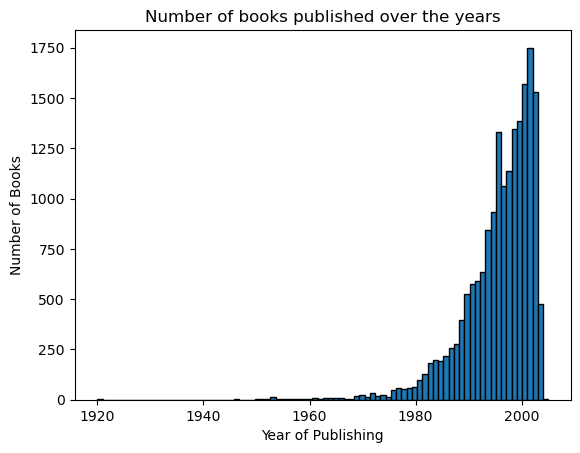

In [42]:
# First let's see how the years of publication is spread to see how we should bin the data
publication_year = books_df["Year-Of-Publication"]
max_yr = max(books_df["Year-Of-Publication"])
min_yr = min(books_df["Year-Of-Publication"])
plt.hist(books_df["Year-Of-Publication"], bins=max_yr-min_yr+1, edgecolor='black')
plt.title("Number of books published over the years")
plt.xlabel("Year of Publishing")
plt.ylabel("Number of Books")
plt.show()

In [43]:
print(f"The earliest book was published in: {min_yr}")
print(f"The latest book was published in: {max_yr}")

The earliest book was published in: 1920
The latest book was published in: 2005


It seems appropraite to bin the data into 4 equal bin widths. This would give around 20 years per bin. We'll label the bins "very old", "old", "recent", "very recent".

In [44]:
# choose labels for my bins
book_year_categories = ["very old", "old", "recent", "very recent"]

# bin the data into 4 quantils
books_df["Year-Of-Publication-Discrete"] = pd.cut(
            books_df["Year-Of-Publication"], bins=4, include_lowest=True, 
            labels=book_year_categories)

#### Discretise Median Age 
We shall be discretising the median ages in the books dataframe

In [45]:
# create age bins, note that ages have been cleaned to range from 0 to 120
age_bins = [0, 5, 13, 19, 26, 36, 46, 66, 120]
age_labels = ["baby", "child", "teen", "early-adult", "early-middle-age", 
              "middle-age", "late-middle-age", "senior"]

# add a discretised age column to the DataFrame
books_df["Median-Age-Discrete"] = pd.cut(books_df["Median-Age"], bins=age_bins, 
                                       labels=age_labels, right=False)

In [46]:
# check out the new age data
print(books_df[["Median-Age", "Median-Age-Discrete"]].head(10))

   Median-Age Median-Age-Discrete
0          32    early-middle-age
1          44          middle-age
2          34    early-middle-age
3          39          middle-age
4          34    early-middle-age
5          29    early-middle-age
6          31    early-middle-age
7          34    early-middle-age
8          33    early-middle-age
9          37          middle-age


#### Discretise Popularity

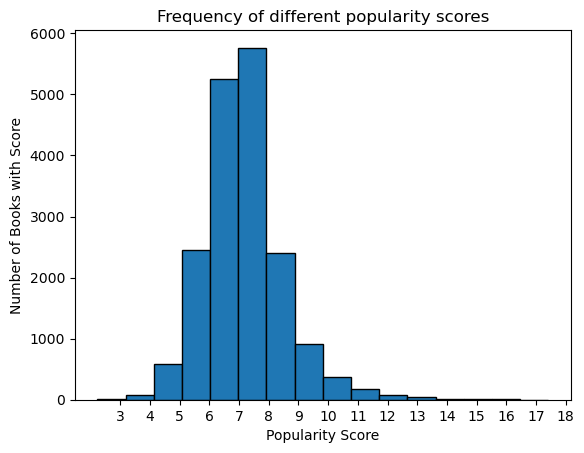

In [47]:
# First let's see how the popularity's spreadpopularity_score to see how we should bin the data
popularity_scores = books_df["Popularity-Score"]
max_score = round(max(popularity_scores))
min_score = round(min(popularity_scores))
plt.hist(books_df["Popularity-Score"], bins=max_score-min_score+1, edgecolor='black')
plt.title("Frequency of different popularity scores")
plt.xlabel("Popularity Score")
plt.ylabel("Number of Books with Score")
plt.xticks([i + 0.5 for i in range(min_score, max_score+1)], [str(i) for i in range(min_score, max_score+1)])
plt.show()

We see that the popularities range from ~2 to ~18, and are not spread equally.
It seems fair to put popularity bins as "low", "low-moderate", "moderate-high" and "high".
We'll split our data into 4 quantiles.

In [48]:
# choose labels for my bins
popularity_categories = ["low", "low-moderate", "moderate-high", "high"]

# bin the data into 4 quantils
books_df["Popularity-Score-Discrete"] = pd.qcut(books_df["Popularity-Score"], 
                                                q=4, 
                                                labels=popularity_categories)

In [49]:
# check out the new binned data
print(books_df[["Popularity-Score", "Popularity-Score-Discrete"]].head(10))

   Popularity-Score Popularity-Score-Discrete
0          7.401325              low-moderate
1          7.443067              low-moderate
2          8.961654                      high
3         13.329749                      high
4         11.594453                      high
5          8.839415                      high
6          9.128301                      high
7          9.361421                      high
8         11.068972                      high
9         13.852491                      high


#### Discretising Country Frequency

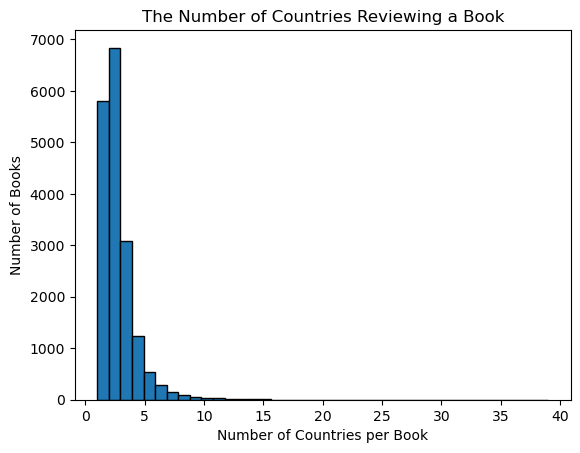

In [50]:
# First let's see how the country frequencies are spread to see how we should bin the data
country_freqs = books_df["Country-Freq"]
max_score = max(country_freqs)
min_score = min(country_freqs)
plt.hist(country_freqs, bins=max_score-min_score+1, edgecolor='black')
plt.title("The Number of Countries Reviewing a Book")
plt.xlabel("Number of Countries per Book")
plt.ylabel("Number of Books")
plt.show()

We see that the country frequencies range from 1 to 39, and are not spread equally. There also seems to be a right tail of much higher, but less commonly occuring frequencies.
It seems fair to put popularity bins as "low", "low-moderate", "moderate-high" and "high".
We'll split our data into 4 equal-width bins.

In [51]:
# choose labels for bins
country_freq_categories = ["low", "low-moderate", "moderate-high", "high"]

# bin the data into 3 quantiles
books_df["Country-Freq-Discrete"] = pd.cut(books_df["Country-Freq"], bins=4, 
                                            include_lowest=True, 
                                            labels=country_freq_categories)

#### Remove all records with a Nan Popularity Score
We do this right off the bat since all our analysis will be the popularity score against some other features. We don't want to work with missing popularity scores, so we'll just get rid of them.

In [52]:
books_df = books_df.dropna(subset=["Popularity-Score"])

In [53]:
# Now save the DataFrame as a new CSV file
books_df.to_csv("BX-Books-Clean.csv", index=False)
users_df.to_csv("BX-Users-Clean.csv", index=False)
ratings_df.to_csv("BX-Ratings-Clean.csv", index=False)